In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np

In [2]:
import enum

In [3]:
import os 

os.chdir('E://bond-dex/bond-amm-simulation/')

In [4]:
df = pd.read_csv('sources/input/actor_trade/synthetic_sample_1.csv')

In [5]:
class Action(enum.Enum):
    
    OPEN_POSITION = 'open_position'
    LIQUIDATE = 'liquidate'
    
class Actor(enum.Enum): 
    
    LENDER = 'lender'
    BORROWER = 'borrower'

In [6]:
def make_action(df, timestamp_pivot): 
    
    df['position'] = df.actor_signal * df.sign
    
    df['actor'] = df.actor_signal.map({1: Actor.LENDER.value, -1: Actor.BORROWER.value})
    df['action'] = df.position.map({1: Action.OPEN_POSITION.value, -1: Action.LIQUIDATE.value})
    
    df['actor'] = np.where(df.timestamp <= timestamp_pivot, 
                           df.sign.map({1: Actor.LENDER.value, -1: Actor.BORROWER.value}), 
                           df.actor)
    df['action'] = np.where(df.timestamp <= timestamp_pivot, Action.OPEN_POSITION.value, df.action)
    
    return df

In [10]:
def make_new_input(df, initial_position=0.4, scale_time=1):
    
    df = df.copy()
    
    df['sign'] = df.action.map({'lend': 1, 'borrow': -1})
    df['net_volume'] = df.cash_volume * df.sign
    df['cum_position'] = df.sort_values(by='timestamp', ascending=True).groupby('action', as_index=False)['net_volume'].cumsum()
    
    time_pivot = df[(df.action == 'lend') & (df.cum_position < initial_position)].timestamp.max()
    actor = np.random.binomial(1, 0.5, size=df.shape[0]) * 2 - 1
    
    df['actor_signal'] = actor
    
    df = make_action(df, time_pivot)
    
    df.timestamp = df.timestamp *  scale_time
    
    return df[['timestamp', 'actor', 'action', 'cash_volume']]

In [11]:
def calibrate_synthetic(source, dest):
    df = pd.read_csv(source)
    
    new_df = make_new_input(df, initial_position=0.3, scale_time=10)
    
    new_df.to_csv(dest, index=False)

In [14]:
sources = ['sources/input/actor_trade/synthetic_sample_1.csv', 
           'sources/input/actor_trade/synthetic_sample_2.csv', 
           'sources/input/actor_trade/synthetic_sample_3.csv']
dests = ['sources/input/actor_trade/synthetic_calibrate_full_1.csv', 
         'sources/input/actor_trade/synthetic_calibrate_full_2.csv', 
         'sources/input/actor_trade/synthetic_calibrate_full_3.csv']

for s, d in zip(sources, dests):
    calibrate_synthetic(s, d)

In [9]:
sources = ['sources/input/actor_trade/single_trade_1.csv']
dests = ['sources/input/actor_trade/extreme_calibrate_1.csv']

for s, d in zip(sources, dests):
    calibrate_synthetic(s, d)

In [78]:
new_df = make_new_input(df)

In [52]:
df['x'] = df.groupby('actor')['net_volume'].cumsum()

<Axes: xlabel='timestamp', ylabel='x'>

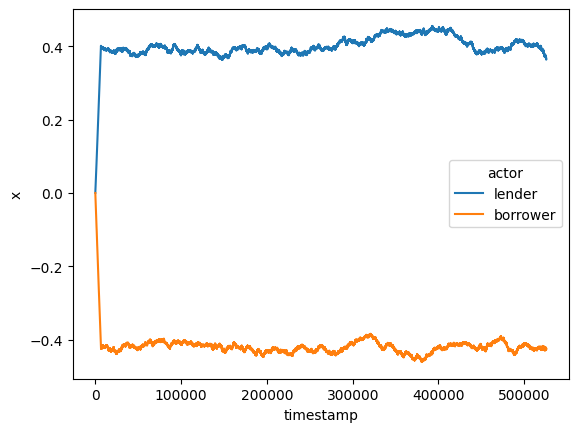

In [54]:
sns.lineplot(data=df, x='timestamp', y='x', hue='actor')

In [87]:
new_df

,timestamp,actor,action,cash_volume
0,1,lender,open_position,0.000174
1,2,lender,open_position,0.000033
2,3,lender,open_position,0.000005
3,4,borrower,open_position,0.000070
4,5,borrower,open_position,0.000021
...,...,...,...,...
525594,525595,lender,liquidate,0.000209
525595,525596,lender,open_position,0.000389
525596,525597,borrower,liquidate,0.000207
525597,525598,lender,liquidate,0.000025
